In [3]:
%load_ext autoreload
import pickle
import sys
sys.path.append('../../..')
import numpy as np
from scipy.interpolate import interp1d
from tqdm import tqdm_notebook as tqdm

import config
import darkhistory.physics as phys
import darkhistory.history.tla as tla
import darkhistory.low_energy.atomic as atomic
import darkhistory.low_energy.bound_free as bf
from plotting_utils import plot_distortion, download_plot

import matplotlib
matplotlib.rc_file('../../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

hplanck = phys.hbar * 2 * np.pi

output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Rather than use fitting functions with fudge factors for the recombination and photo-ionization coefficients, $\alpha_B$ and $\beta_B$, we now calculate them.  To test if we have done so correctly we calculate $x_e(z)$ and compare to the solid line in Fig. 3 of [1011.3758](https://arxiv.org/pdf/1011.3758.pdf), Hyrec's paper.

In [4]:
# Download Hyrec plots
EMLA_data = download_plot('EMLA', config.data_path)
Rec_data = download_plot('Recfast', config.data_path)

In [8]:
eng = np.exp(np.linspace(
    np.log(hplanck*1e8), np.log(phys.rydberg), 500))

rs_list = np.exp(np.arange(np.log(2e3), 5., -.001*4))

baseline = tla.get_history(rs_list, high_rs=1.555e3,
                           fudge=1.0, gauss_fudge=False, rtol=1e-8)
fudge_1_14 = tla.get_history(rs_list, high_rs=1.555e3,
                             fudge=1.14, gauss_fudge=False, rtol=1e-8)

dist_eng = np.exp(np.linspace(np.log(hplanck*1e8), np.log(phys.rydberg), 10))

nmax_list = [50,100,200]#,300]

In [6]:
nmax_convergence_alt = pickle.load(open(output_dir+'nmax_convergence.dat', 'rb'))

In [ ]:
%autoreload
nmax_convergence_alt = {}
for nmax in nmax_list:
    R = atomic.populate_radial(nmax)
    Thetas = bf.populate_thetas(nmax)

    MLA_data = np.zeros((rs_list.size, 3))
    for i, rs in enumerate(tqdm(rs_list)):

        MLA_data[i], _ = atomic.process_MLA(
            rs, 1, phys.x_std(rs, 'HI'), 
            phys.Tm_std(rs), nmax, eng, R, Thetas
        )

    MLA_funcs = [interp1d(rs_list, MLA_data[:,i], fill_value='extrapolate')
                 for i in range(3)]

    nmax_convergence_alt[nmax] = tla.get_history(
        rs_list, high_rs=1.555e3,
        recfast_TLA=False, MLA_funcs=MLA_funcs,
        rtol=1e-8
    )
    pickle.dump(nmax_convergence_alt, open(output_dir+'nmax_convergence.dat', 'wb'))

../../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


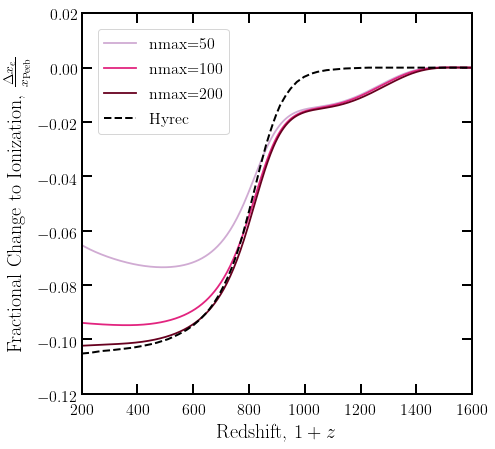

In [11]:
%autoreload
plt.figure(figsize=(7,7))
plt.axis([200,1600, -.12,.02])
ax = plt.gca()

color = iter(plt.cm.PuRd(np.linspace(0.3, 1, len(nmax_list))))

for i,nmax in enumerate(nmax_list):
    c = next(color)
    ax.plot(rs_list, nmax_convergence_alt[nmax][:,1]/baseline[:,1]-1, 
            linewidth = 1.8, label=r'nmax='+str(nmax), c=c)
   
# ax.plot(rs_list, nmax_convergence_alt[50][:,1]/baseline[:,1]-1, 
#          linewidth = 1.8, label=r'$2s\to 1s$ BB')
# ax.plot(rs_list, tmp/baseline[:,1]-1, 
#              linewidth = 1.8, label=r'$2s\to 1s$ vacuum')

# hyrec plots
lw = 1.2
ax.plot(EMLA_data[:,0], EMLA_data[:,1], color='black', 
         linewidth = 2.0, linestyle = '--', 
         label=r'Hyrec')


# plot labels
ax.set_xlabel(r'Redshift, $1+z$', fontsize=20)
ax.set_ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{Peeb}}}$', fontsize=20)
ax.legend()

plt.savefig(fig_dir+'Hyrec_xe_crosscheck.pdf')